In [1]:
# Load Dataset

import torch
dataset = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined_2.pt",weights_only=False)

In [ ]:
## Heterogeneous Graph Transformer - Dynamic over timesteps
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import HGTConv, Linear
import time
import torch
import numpy as np
import tqdm

#dataset = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined.pt",weights_only=False)
print(dataset[0].metadata())
device = 'cpu'
data = dataset[0]
#print(data.keys)

#data = T.AddSelfLoops()(data)
#data = T.NormalizeFeatures()(data)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype  = torch.float32  # pick one dtype and stick to it

t = -1  # last timestep

# --- Nodes ---
pos   = data['nodes'].pos.to(device=device, dtype=dtype)
bc    = data['nodes'].bc.to(device=device, dtype=dtype)
#u_ts  = data['nodes'].u_ts[t].to(device=device, dtype=dtype)
f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(device=device, dtype=dtype)
f_int = data['nodes'].f_int[t].to(device=device, dtype=dtype)

data['nodes'].x = torch.cat([pos, bc, u_ts, f_ext, f_int], dim=-1)

# --- Elements ---
# material might be Long/Int; convert to float for concatenation
mat  = data['elements'].material.to(device=device)
if mat.dtype != dtype:
    mat = mat.float()

S = data['elements'].s_ts[t].to(device=device, dtype=dtype).reshape(-1, 9)

data['elements'].x = torch.cat([mat, S], dim=-1)

# --- HGTConv wiring ---
metadata = data.metadata()
conv = HGTConv(
    in_channels={'nodes': data['nodes'].x.size(-1),
                 'elements': data['elements'].x.size(-1)},
    out_channels=128,
    metadata=metadata,
    heads=2
).to(device)

out = conv(data.x_dict, data.edge_index_dict)


(['nodes', 'elements'], [('elements', 'contributes', 'nodes'), ('nodes', 'belongs_to', 'elements'), ('nodes', 'adjacent', 'nodes'), ('nodes', 'adjacent_rev', 'nodes')])


In [ ]:
## HGT - single graph

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear

device = torch.device('cuda:1')
dtype  = torch.float32
t = -1  # last timestep
data = dataset[0]

# ----- Build features (NO leakage: don't include u_ts in node input) -----
# Nodes: x_n = [pos, bc, f_ext[t], f_int[t]]
x_nodes = torch.cat([
    data['nodes'].pos.to(device=device, dtype=dtype),
    data['nodes'].bc.to(device=device, dtype=dtype),
    torch.Tensor(data['nodes'].f_ext[t]).to(device=device, dtype=dtype),
    data['nodes'].f_int[t].to(device=device, dtype=dtype),
], dim=-1)

# Elements: x_e = [material (float), s_ts[t] (flattened 3x3)]
mat = data['elements'].material.to(device=device)
if mat.dtype != dtype:
    mat = mat.float()
S = data['elements'].s_ts[t].to(device=device, dtype=dtype).reshape(-1, 9)
x_elems = torch.cat([mat, S], dim=-1)

# Assign x
data['nodes'].x = x_nodes
data['elements'].x = x_elems

# ----- Targets (node-level regression to u_ts[t] -> 3D) -----
y_nodes = data['nodes'].u_ts[t].to(device=device, dtype=dtype)  # [N_nodes, 3]

# Optional masks (if you have them). Otherwise default to all True.
train_mask = getattr(data['nodes'], 'train_mask', torch.ones(y_nodes.size(0), dtype=torch.bool, device=device))
val_mask   = getattr(data['nodes'], 'val_mask',   torch.zeros(y_nodes.size(0), dtype=torch.bool, device=device))
if val_mask.sum() == 0:  # simple split if none provided
    n = y_nodes.size(0)
    perm = torch.randperm(n, device=device)
    val_sz = max(1, int(0.1 * n))
    val_idx = perm[:val_sz]
    train_idx = perm[val_sz:]
    train_mask = torch.zeros(n, dtype=torch.bool, device=device); train_mask[train_idx] = True
    val_mask   = torch.zeros(n, dtype=torch.bool, device=device); val_mask[val_idx]   = True

# Move graph connectivity to device
x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}

# ----- Model -----
class HGTNodeRegressor(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2, out_dim_nodes=3):
        super().__init__()
        self.lin_in = nn.ModuleDict({
            'nodes':   Linear(in_dims['nodes'], hidden),
            'elements':Linear(in_dims['elements'], hidden),
        })
        self.conv1 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.conv2 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        # Head only for 'nodes' (we predict on nodes)
        self.head_nodes = nn.Sequential(
            Linear(hidden, hidden),
            nn.ReLU(),
            Linear(hidden, out_dim_nodes)
        )

    def forward(self, x_dict, edge_index_dict):
        # per-type input projection
        x = {k: F.relu(self.lin_in[k](x_dict[k])) for k in x_dict.keys() if k in self.lin_in}
        x = self.conv1(x, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)
        pred_nodes = self.head_nodes(x['nodes'])
        return pred_nodes

metadata = data.metadata()
in_dims = {'nodes': data['nodes'].x.size(-1),
           'elements': data['elements'].x.size(-1)}

model = HGTNodeRegressor(metadata, in_dims, hidden=128, heads=2, out_dim_nodes=3).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

def masked_mse(pred, target, mask):
    if mask.sum() == 0:
        return torch.tensor(0.0, device=pred.device)
    diff = pred[mask] - target[mask]
    return (diff**2).mean()

best_val = float('inf')
best_state = None

EPOCHS = 200
clip_norm = 1.0

for epoch in range(1, EPOCHS+1):
    model.train()
    opt.zero_grad()
    pred = model(x_dict, edge_index_dict)          # [N_nodes, 3]
    loss = masked_mse(pred, y_nodes, train_mask)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    opt.step()

    # Validation
    model.eval()
    with torch.no_grad():
        pred_val = model(x_dict, edge_index_dict)
        val_loss = masked_mse(pred_val, y_nodes, val_mask)

    scheduler.step(val_loss)

    if val_loss.item() < best_val:
        best_val = val_loss.item()
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train MSE: {loss.item():.6f} | val MSE: {val_loss.item():.6f}")

# Load best and save
if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "hgt_node_regressor_single.pt")
print("Best val MSE:", best_val)


Epoch 001 | train MSE: 0.080259 | val MSE: 0.282765
Epoch 010 | train MSE: 0.006892 | val MSE: 0.004436
Epoch 020 | train MSE: 0.002358 | val MSE: 0.002204
Epoch 030 | train MSE: 0.001018 | val MSE: 0.000896
Epoch 040 | train MSE: 0.000526 | val MSE: 0.000568
Epoch 050 | train MSE: 0.000350 | val MSE: 0.000393
Epoch 060 | train MSE: 0.000235 | val MSE: 0.000269
Epoch 070 | train MSE: 0.000181 | val MSE: 0.000210
Epoch 080 | train MSE: 0.000140 | val MSE: 0.000164
Epoch 090 | train MSE: 0.000116 | val MSE: 0.000136
Epoch 100 | train MSE: 0.000098 | val MSE: 0.000117
Epoch 110 | train MSE: 0.000085 | val MSE: 0.000102
Epoch 120 | train MSE: 0.000189 | val MSE: 0.000271
Epoch 130 | train MSE: 0.000078 | val MSE: 0.000106
Epoch 140 | train MSE: 0.000079 | val MSE: 0.000086
Epoch 150 | train MSE: 0.000060 | val MSE: 0.000069
Epoch 160 | train MSE: 0.000052 | val MSE: 0.000062
Epoch 170 | train MSE: 0.000046 | val MSE: 0.000058
Epoch 180 | train MSE: 0.000041 | val MSE: 0.000051
Epoch 190 | 

In [ ]:
## Training loop with HGT - multiple samples single output
# Problems: loss does not decrease, key data discarded

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
import pandas as pd

## Collapse to peak load timestep

def build_laststep_features(data, dtype=torch.float32):
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    pos   = data['nodes'].pos.to(dtype)
    bc    = data['nodes'].bc.to(dtype)
    #f_int = data['nodes'].f_int[t].to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([pos, bc, f_ext], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    #S = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes → u_ts[-1] (3D)
    data['nodes'].y = data['nodes'].u_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].pos, data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int, data['elements'].s_ts, data['elements'].d_ts, data['elements'].material
    #print(data.keys)

    return data

# Apply to every sample in your dataset (list-like or PyG Dataset):
# dataset = [build_laststep_features(d) for d in dataset]

# If you have a PyG Dataset object that supports transforms:
# dataset.transform = build_laststep_features

# ----------------------------
# 2) Dataloaders (train/val split)
# ----------------------------
def split_dataset(dataset, val_ratio=0.1, shuffle=True):
    n = len(dataset)
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    n_val = max(1, int(n * val_ratio))
    val_idx = idx[:n_val].tolist()
    train_idx = idx[n_val:].tolist()
    train_set = [dataset[i] for i in train_idx]
    val_set   = [dataset[i] for i in val_idx]
    return train_set, val_set

# preprocess first
dataset = [build_laststep_features(d) for d in dataset]
train_set, val_set = split_dataset(dataset, val_ratio=0.1)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)  # adjust batch_size to your memory
val_loader   = DataLoader(val_set,   batch_size=4, shuffle=False)

## HGT Model
class HGTNodeRegressor(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2, out_dim_nodes=3):
        super().__init__()
        self.lin_in = nn.ModuleDict({
            'nodes':    Linear(in_dims['nodes'], hidden),
            'elements': Linear(in_dims['elements'], hidden),
        })
        self.conv1 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.conv2 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.head_nodes = nn.Sequential(
            Linear(hidden, hidden),
            nn.ReLU(),
            Linear(hidden, out_dim_nodes)
        )

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin_in[k](x_dict[k])) for k in self.lin_in.keys()}
        x = self.conv1(x, edge_index_dict)
        x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)
        pred_nodes = self.head_nodes(x['nodes'])
        return pred_nodes

#device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# infer metadata and input dims from the first sample
metadata = dataset[0].metadata()
in_dims = {
    'nodes':    dataset[0]['nodes'].x.size(-1),
    'elements': dataset[0]['elements'].x.size(-1),
}

model = HGTNodeRegressor(metadata, in_dims, hidden=128, heads=2, out_dim_nodes=3).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-2, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

def masked_mse(pred, target, mask=None):
    if mask is None:
        return F.mse_loss(pred, target)
    if mask.sum() == 0:
        return torch.tensor(0.0, device=pred.device)
    return F.mse_loss(pred[mask], target[mask])

# ----------------------------
# 4) Training / Validation
# ----------------------------
EPOCHS = 400
clip_norm = 1.0
best_val = float('inf')
best_state = None

losses = [('train_loss','val_loss')]
for epoch in range(1, EPOCHS + 1):
    # ----- train -----
    model.train()
    running = 0.0
    nb = 0
    for batch in train_loader:
        batch = batch.to(device)
        opt.zero_grad()
        pred = model(batch.x_dict, batch.edge_index_dict)   # [sum_nodes_in_batch, 3]
        y = batch['nodes'].y
        # Optional per-node train mask: batch['nodes'].train_mask if you have it
        #loss = masked_mse(pred, y, mask=getattr(batch['nodes'], 'train_mask', None))
        loss = F.mse_loss(pred,y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        opt.step()
        running += loss.item()
        nb += 1
    train_loss = running / max(1, nb)

    # ----- validate -----
    model.eval()
    running = 0.0
    nb = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            pred = model(batch.x_dict, batch.edge_index_dict)
            y = batch['nodes'].y
            #val_loss = masked_mse(pred, y, mask=getattr(batch['nodes'], 'val_mask', None))
            val_loss = F.mse_loss(pred,y)
            running += val_loss.item()
            nb += 1
    val_loss = running / max(1, nb)
    scheduler.step(val_loss)
    losses.append((train_loss,val_loss))

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train MSE: {train_loss:.6f} | val MSE: {val_loss:.6f}")
# restore best and save
if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "hgt_node_regressor_best_2.pt")
print("Best val MSE:", best_val)
loss_df = pd.DataFrame(losses)
loss_df.to_csv('training_loss_2.csv')

##TODO:
# temporal model
# variables which are both inputs and outputs
# multi-head output
# smooth meshes

Epoch 001 | train MSE: 13152.991484 | val MSE: 2.110153


KeyboardInterrupt: 

In [ ]:
## Training loop with Multi-Head HGT

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader
import pandas as pd

## Collapse to peak load timestep

def build_laststep_features(data, dtype=torch.float32):
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    pos   = data['nodes'].pos.to(dtype)
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].fext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([pos, bc, f_ext], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes → u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_int[t].to(dtype)
    
    # Target: elements
    data['elements'].y_s = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    #data['elements'].y_d = data['elements'].d_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].pos, data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int, data['elements'].s_ts, data['elements'].d_ts, data['elements'].material
    #print(data.keys)

    return data

# Apply to every sample in your dataset (list-like or PyG Dataset):
# dataset = [build_laststep_features(d) for d in dataset]

# If you have a PyG Dataset object that supports transforms:
# dataset.transform = build_laststep_features


## DataLoader with train/val split
dataset = [build_laststep_features(d) for d in dataset]

def split_dataset(dataset, val_ratio=0.1, shuffle=True):
    n = len(dataset)
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    n_val = max(1, int(n * val_ratio))
    val_idx = idx[:n_val].tolist()
    train_idx = idx[n_val:].tolist()
    train_set = [dataset[i] for i in train_idx]
    val_set   = [dataset[i] for i in val_idx]
    return train_set, val_set

# preprocess first
train_set, val_set = split_dataset(dataset, val_ratio=0.1)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)  # adjust batch_size to your memory
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False)

## HGT Model
class HGTMultipleOutput(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2):
        super().__init__()
        self.lin_in = nn.ModuleDict({
            'nodes':    Linear(in_dims['nodes'], hidden),
            'elements': Linear(in_dims['elements'], hidden),
        })
        self.conv1 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.conv2 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.head_u    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → u
        self.head_fint = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → f_int
        self.head_s    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 9))   # elements → s (3x3)
        self.head_d    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 1))   # elements → d (optional)

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin_in[k](x_dict[k])) for k in self.lin_in.keys()}
        x = self.conv1(x, edge_index_dict); x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)

        h_nodes    = x['nodes']
        h_elements = x['elements']

        pred_u    = self.head_u(h_nodes)
        pred_fint = self.head_fint(h_nodes)
        pred_s    = self.head_s(h_elements)
        #pred_d    = self.head_d(h_elements)  # you can ignore this if d is missing

        return {'u': pred_u, 'fint': pred_fint, 's': pred_s}#, 'd': pred_d}
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# infer metadata and input dims from the first sample
metadata = dataset[0].metadata()
in_dims = {
    'nodes':    dataset[0]['nodes'].x.size(-1),
    'elements': dataset[0]['elements'].x.size(-1),
}

model = HGTMultipleOutput(metadata, in_dims, hidden=32, heads=2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

## Losses
ALPHA_FINT = 0.5   # node f_int aux
BETA_S     = 0.2   # element stress aux
GAMMA_D    = 0.1   # element damage aux (used only if available)
LAMBDA_EQ  = 0.1   # equilibrium regularizer on nodes

def compute_losses(batch, pred):
    # Nodes
    y_u    = batch['nodes'].y_u
    y_fint = batch['nodes'].y_fint
    fext   = batch['nodes'].fext
    pu, pf = pred['u'], pred['fint']

    L_u    = F.mse_loss(pu, y_u)
    L_fint = F.mse_loss(pf, y_fint)
    L_eq   = F.mse_loss(pf + fext, torch.zeros_like(fext))

    # Elements
    ps = pred['s']
    ys = batch['elements'].y_s
    L_s = F.mse_loss(ps, ys)

    # Optional damage
    #L_d = torch.tensor(0.0, device=pu.device)
    #if batch['elements'].y_d is not None:
    #    yd = batch['elements'].y_d
    #    pd = pred['d']
    #    L_d = F.mse_loss(pd, yd)

    loss = L_u + ALPHA_FINT * L_fint + LAMBDA_EQ * L_eq + BETA_S * L_s #+ GAMMA_D * L_d
    return loss, {'L_u': L_u.item(), 'L_fint': L_fint.item(), 'L_eq': L_eq.item(),
                  'L_s': L_s.item()}#, 'L_d': L_d.item()}


## Training Loop

def run_epoch(loader, train=True):
    model.train(train)
    total = 0.0; n = 0
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad(set_to_none=True)
        pred = model(batch.x_dict, batch.edge_index_dict)
        loss, _ = compute_losses(batch, pred)
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total += loss.item(); n += 1
    return total / max(1, n)


EPOCHS = 200
best_val = float('inf')
best_state = None

losses = [('train_loss','val_loss')]

for epoch in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, train=True)
    model.eval()
    with torch.no_grad():
        va = run_epoch(val_loader, train=False)
    scheduler.step(va)
    losses.append((tr,va))
    if va < best_val:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train {tr:.6f} | val {va:.6f}")

if best_state is not None:
    model.load_state_dict(best_state)
torch.save(model.state_dict(), "hgt_multitask_best.pt")
print("Best val:", best_val)

loss_df = pd.DataFrame(losses)
loss_df.to_csv('training_loss_multihead.csv')

##FIXES:
# normalize features
# add self-loops if any connections are missing
# damage mechanism not present for all material types --> make robust
# mask to free-dof nodes??
# check loss functions

##TODO:
# temporal model
# variables which are both inputs and outputs
# smooth meshes
# material stress-strain curve

Epoch 001 | train 12777.851004 | val 732.498341
Epoch 010 | train 11634.513447 | val 510.645548
Epoch 020 | train 11274.627981 | val 494.664419
Epoch 030 | train 11264.297840 | val 487.662880
Epoch 040 | train 11170.771170 | val 487.977738
Epoch 050 | train 11091.819914 | val 494.170233
Epoch 060 | train 11011.371102 | val 503.953645
Epoch 070 | train 10953.312131 | val 504.784340
Epoch 080 | train 10895.011126 | val 516.853371
Epoch 090 | train 10870.628696 | val 519.589339
Epoch 100 | train 10859.833914 | val 520.292504
Epoch 110 | train 10853.860819 | val 522.355557
Epoch 120 | train 10852.842432 | val 519.799853
Epoch 130 | train 10851.281198 | val 518.910646
Epoch 140 | train 10849.714332 | val 518.783911
Epoch 150 | train 10849.564232 | val 518.700704
Epoch 160 | train 10849.603184 | val 518.617200
Epoch 170 | train 10849.459579 | val 518.622733
Epoch 180 | train 10849.451977 | val 518.609855
Epoch 190 | train 10849.432018 | val 518.601657
Epoch 200 | train 10849.417218 | val 518

C:\Users\bm_tu\AppData\Local\Temp\ipykernel_11260\2733833976.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


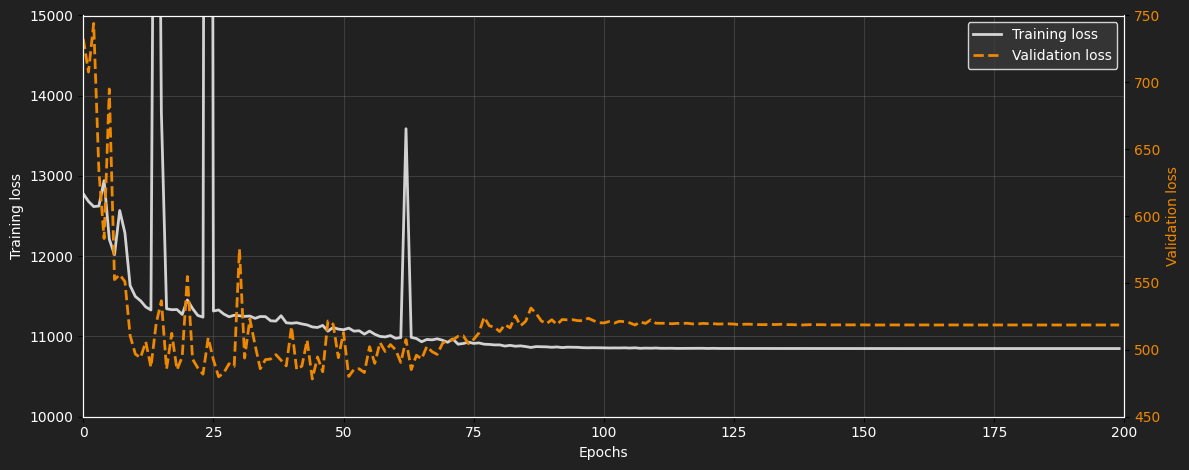

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

loss_np = np.array(losses[1:])
#loss_np = pd.read_csv('training_loss_2.csv').to_numpy()

plt, ax1 = plt.subplots()
plt.set_figwidth(12)
plt.patch.set_facecolor('#212121')
ax1.set_facecolor('#212121')  
ax1.grid(alpha=0.2)
x = np.arange(0,loss_np.shape[0])
ax1.plot(x, loss_np[:,0], label='Training loss', linewidth=2,color='white',alpha=0.8)
ax1.set_xlabel('Epochs',color='white')
ax1.set_ylim(10000,15000)
ax1.set_ylabel('Training loss', color='white')
ax1.tick_params(axis='x', labelcolor='white')
ax1.tick_params(axis='y', labelcolor='white')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, loss_np[:,1], color='#ee8800', label='Validation loss', linewidth=2, linestyle='--')
ax2.set_ylim(450,750)
ax2.set_ylabel('Validation loss', color='#ee8800')
ax2.tick_params(axis='y', labelcolor='#ee8800')

for spine in ax1.spines.values():
    spine.set_color('white')
for spine in ax2.spines.values():
    spine.set_color('white')


ax1.set_xlim(0,200)
# Optional: combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', facecolor='#3a3a3a', edgecolor='white', labelcolor='white')
plt.tight_layout()
plt.show()

In [ ]:
## Validation Cases
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import glob
import numpy as np
import torch
from torch_geometric.data import HeteroData
import pandas as pd

# Material encoding (1-h)
def load_material_vocab() -> Tuple[Dict[str, int], Dict[int, str]]:
    # CSV: idx,label
    #df = pd.read_csv(materials_csv, header=None, names=["sim_id", "label"])
    #labels = sorted(df["label"].astype(str).unique().tolist())
    labels = ['concrete','steel','aluminum','CFRP'] #0,1,2,3 fixed material labels for now
    vocab = {lbl: i for i, lbl in enumerate(labels)}
    return vocab

def one_hot(label: str, vocab: Dict[str, int], device=None, dtype=torch.float) -> torch.Tensor:
    vec = torch.zeros(len(vocab), dtype=dtype, device=device)
    vec[vocab[label]] = 1.0
    return vec

def stiffness_to_node_adj_edge_index(K: torch.Tensor, num_nodes: int, dof_per_node: int = 3) -> torch.Tensor: #mesh-mesh nodes
    K = K.coalesce()
    dof_rows, dof_cols = K.indices()
    node_rows = torch.div(dof_rows, dof_per_node, rounding_mode="floor")
    node_cols = torch.div(dof_cols, dof_per_node, rounding_mode="floor")
    ei = torch.stack([node_rows.long(), node_cols.long()], dim=0)
    mask = ei[0] != ei[1]
    ei = ei[:, mask]
    ei = torch.unique(ei, dim=1)
    return ei

def incidence_edges_from_conn(conn: np.ndarray, nodes: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    Nc, Nv = conn.shape
    c_idx = np.repeat(np.arange(Nc, dtype=np.int64), Nv)
    n_idx = conn.reshape(-1)
    edge_index = torch.from_numpy(np.vstack([c_idx, n_idx])).long()
    node_tensor = nodes.to(edge_index.device)
    conn_tensor = torch.from_numpy(conn).long().to(edge_index.device)
    #edge attribute -> mesh to element centroid in xyz
    elem_nodes = node_tensor[conn_tensor]
    centroids = elem_nodes.mean(dim=1, keepdim=True)
    rel_disp = (elem_nodes - centroids).reshape(-1, elem_nodes.size(-1))

    return edge_index, rel_disp

# Connectivity
# mesh nodes <-> mesh nodes
# mesh nodes <-> element nodes

def data_to_graph(path:str,device):
    data = HeteroData()
    vocab = load_material_vocab()
    simdata = torch.load(path,weights_only=False)
    conn = simdata["elements"]
    conn = conn.cpu().numpy() if isinstance(conn, torch.Tensor) else np.asarray(conn)
    nodes = simdata['nodes']
    label = simdata['material']
    c2n_ei, c2n_w = incidence_edges_from_conn(conn,nodes)  # [2, E_cn], [E_cn, 1]
    
    # mesh node properties: positions, internal forces, BC, dirichlet displacement
    data['nodes'].pos = nodes #                                             [N,3]
    data['nodes'].f_ext = simdata['ext_forces'] #external forces            [T,N,3]
    data['nodes'].bc = simdata['boundary'] #                                [N,3]
    #data['nodes'].dr = simdata['dirichlet_disp'] #dirichlet displacement   [N,3]

    # element node properties: material, stiffness matrix
    data['elements'].material = one_hot(label, vocab, device=device).unsqueeze(0).repeat(int(conn.shape[0]), 1) # [E,len(materials)]
    #data['elements'].stiffness = #stiffness is a learned feature

    # target properties
    # mesh: displacement over time
    # element: stress, damage state, internal forces
    data['nodes'].u_ts = simdata['u_history'] #                                     [T,N,3]
    data['elements'].s_ts = simdata['stress_history'] #                             [T,E,3]
    data['elements'].d_ts = simdata['state']
    data['nodes'].f_int = simdata['forces'] #internal forces in timeseries format     [T,N,3]

    # edges: connectivity mesh-mesh, mesh-element
    # mesh-element: distance to element centroid
    data["elements", "contributes", "nodes"].edge_index = c2n_ei
    data["elements", "contributes", "nodes"].edge_attr = c2n_w
    data["nodes", "belongs_to", "elements"].edge_index = c2n_ei.flip(0)
    data["nodes", "belongs_to", "elements"].edge_attr = c2n_w.flip(0)
    data['elements'].num_nodes = simdata['stress_history'].size(1)

    # mesh-mesh: distance
    ei = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1))
    data["nodes", "adjacent", "nodes"].edge_index = ei
    data["nodes", "adjacent_rev", "nodes"].edge_index = ei.flip(0)
    data["nodes", "adjacent", "nodes"].edge_attr = (nodes[ei[1]] - nodes[ei[0]]).float()

    #data['elements'].edge_index = simdata['elements'] #mesh-element [E,8]
    #data['nodes'].edge_index = stiffness_to_node_adj_edge_index(simdata["stiffness"], num_nodes=nodes.size(0), dof_per_node=nodes.size(1)) #from stiffness matrix, only connectivity

    # for debugging dimensions
    #print(data['nodes'].num_nodes)                              # N
    #print(data['elements'].num_nodes)                           # E
    #print(data.num_edges)                                       # 2*((E*num_vertices)+())
    #print(data['nodes','adjacent','nodes'].num_edges)           # 
    #print(data['nodes','adjacent_rev','nodes'].num_edges)       #
    #print(data['elements','contributes','nodes'].num_edges)     # E*num_vertices
    #print(data['nodes','belongs_to','elements'].num_edges)      # E*num_vertices

    #data = data.pin_memory()
    data = data.to(device)
    return data

#data_to_graph('../torchfem_dataset/panel_plasticity_2/simulation_dump_3.pt',device)

device = torch.device('cpu')
data_dir = '../torchfem_dataset/panel_plasticity_2/'
files = (Path(data_dir).glob("simulation_dump_15*.pt"))
samples = []
for file in files:
    if '150' in str(file):
        continue
    data = data_to_graph(file,device)
    samples.append(data)
    print(file)
#print(len(files))


..\torchfem_dataset\panel_plasticity_2\simulation_dump_151.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_152.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_153.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_154.pt
..\torchfem_dataset\panel_plasticity_2\simulation_dump_155.pt


RuntimeError: Parent directory ../test_dataset does not exist.

In [91]:
torch.save(samples, "../base/test_dataset/test_combined.pt")

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import HGTConv, Linear
from torch_geometric.loader import DataLoader

device = torch.device('cpu')
#samples = torch.load("../base/test_dataset/test_combined.pt",weights_only=False)
samples = torch.load("../torchfem_dataset/panel_plasticity_2/panel_combined_2.pt",weights_only=False)

def build_laststep_features(data, dtype=torch.float32):
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len/2-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    pos   = data['nodes'].pos.to(dtype)
    bc    = data['nodes'].bc.to(dtype)
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].fext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([pos, bc, f_ext], dim=-1)

    # Elements: x = [material (float), s_ts[-1].flatten(9)]
    mat = data['elements'].material
    if not torch.is_floating_point(mat):
        mat = mat.float()
    data['elements'].x = mat#torch.cat([mat], dim=-1)

    # Target: nodes → u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_int[t].to(dtype)
    
    # Target: elements
    data['elements'].y_s = data['elements'].s_ts[t].to(dtype).reshape(-1, 9)
    #data['elements'].y_d = data['elements'].d_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].pos, data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int, data['elements'].s_ts, data['elements'].d_ts, data['elements'].material
    #print(data.keys)

    return data

samples_dataset = [build_laststep_features(d) for d in samples]

## HGT Model
class HGTMultipleOutput(nn.Module):
    def __init__(self, metadata, in_dims, hidden=128, heads=2):
        super().__init__()
        self.lin_in = nn.ModuleDict({
            'nodes':    Linear(in_dims['nodes'], hidden),
            'elements': Linear(in_dims['elements'], hidden),
        })
        self.conv1 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.conv2 = HGTConv(in_channels={k: hidden for k in in_dims},
                             out_channels=hidden,
                             metadata=metadata,
                             heads=heads)
        self.head_u    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → u
        self.head_fint = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 3))   # nodes → f_int
        self.head_s    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 9))   # elements → s (3x3)
        self.head_d    = nn.Sequential(Linear(hidden, hidden), nn.ReLU(), Linear(hidden, 1))   # elements → d (optional)

    def forward(self, x_dict, edge_index_dict):
        x = {k: F.relu(self.lin_in[k](x_dict[k])) for k in self.lin_in.keys()}
        x = self.conv1(x, edge_index_dict); x = {k: F.relu(v) for k, v in x.items()}
        x = self.conv2(x, edge_index_dict)

        h_nodes    = x['nodes']
        h_elements = x['elements']

        pred_u    = self.head_u(h_nodes)
        pred_fint = self.head_fint(h_nodes)
        pred_s    = self.head_s(h_elements)
        #pred_d    = self.head_d(h_elements)  # you can ignore this if d is missing

        return {'u': pred_u, 'fint': pred_fint, 's': pred_s}#, 'd': pred_d}
    
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# infer metadata and input dims from the first sample
metadata = samples_dataset[0].metadata()
in_dims = {
    'nodes':    samples_dataset[0]['nodes'].x.size(-1),
    'elements': samples_dataset[0]['elements'].x.size(-1),
}

model = HGTMultipleOutput(metadata, in_dims, hidden=32, heads=2).to(device)
model_state = torch.load('hgt_multitask_best.pt')
model.load_state_dict(model_state)
model.eval()

sample_loader   = DataLoader(samples_dataset,   batch_size=1, shuffle=True)
sample = next(iter(sample_loader))
batch = sample.to(device)
#print(batch['nodes'].keys())
pred = model(batch.x_dict, batch.edge_index_dict)

In [97]:
from copy import deepcopy

out_samples = []
with torch.no_grad():
    for i, data in enumerate(samples_dataset):
        d = deepcopy(data)         # keep originals intact
        d = d.to(device)

        pred = model(d.x_dict, d.edge_index_dict)  # returns dict: {'u','fint','s'}

        # Detach and move predictions to CPU for saving
        pu = pred['u'].detach().cpu()
        pf = pred['fint'].detach().cpu()
        ps = pred['s'].detach().cpu()

        # Move the data structure back to CPU before attaching CPU tensors
        d = d.to('cpu')

        # Attach predictions into the dictionary
        d['nodes'].pred_u = pu
        d['nodes'].pred_fint = pf
        d['elements'].pred_s = ps

        out_samples.append(d)

# Save to a new file
save_path = "../base/test_dataset/test_combined_with_preds.pt"
#torch.save(out_samples, save_path)
print(f"Saved {len(out_samples)} samples with predictions to {save_path}")

Saved 113 samples with predictions to ../base/test_dataset/test_combined_with_preds.pt


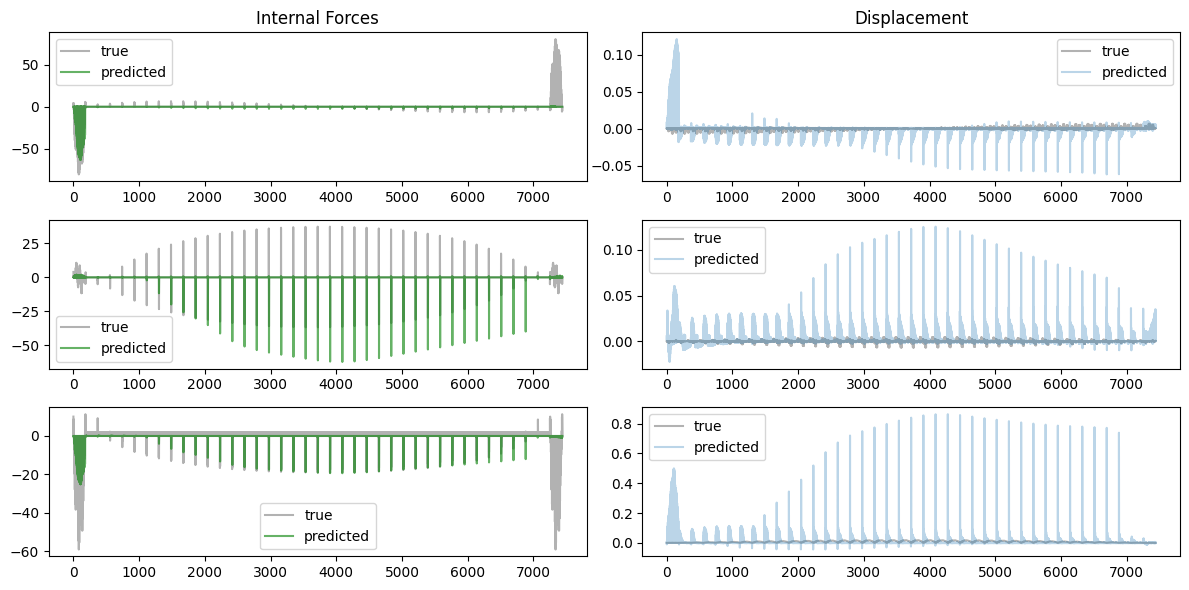

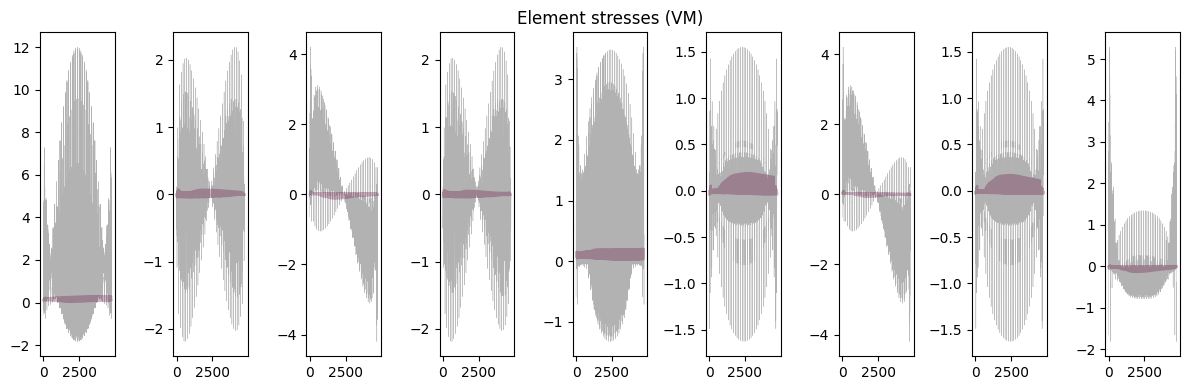

In [161]:
import matplotlib.pyplot as plt
#out_samples = torch.load("../base/test_dataset/test_combined_with_preds.pt")

fig, ax = plt.subplots(3,2)
fig.set_figwidth(12)
fig.set_figheight(6)
sample = 73

ax[0,0].set_title('Internal Forces')
ax[0,1].set_title('Displacement')

for i in range(3):
    ax[i,1].plot(out_samples[sample]['nodes']['y_u'][:,i],'k',alpha=0.3,label='true')
    ax[i,1].plot(out_samples[sample]['nodes']['pred_u'][:,i],alpha=0.3,label='predicted')
    ax[i,1].legend()
    
    ax[i,0].plot(out_samples[sample]['nodes']['y_fint'][:,i],'k',alpha=0.3,label='true')
    ax[i,0].plot(out_samples[sample]['nodes']['pred_fint'][:,i],color='green',alpha=0.6,label='predicted')
    ax[i,0].legend()
plt.tight_layout()


fig, ax = plt.subplots(1,9)
fig.set_figwidth(12)
fig.set_figheight(4)
ax[4].set_title('Element stresses (VM)')
for i in range(9):
    ax[i].plot(out_samples[sample]['elements']['y_s'][:,i],'k',linewidth=0.3,alpha=0.3)
    ax[i].plot(out_samples[sample]['elements']['pred_s'][:,i],color='#661144',alpha=0.3)
plt.tight_layout()


In [20]:
import torch
sim = torch.load('../base/euler_dataset/panel_plasticity_2/simulation_dump_20.pt')
fint = sim['forces'].detach().cpu().numpy()
fext = sim['ext_forces']
t = 15
ext_t = fext[t].sum()
x_eq = (fint[t,:,0]-fext[t,:,0]).sum()
y_eq = (fint[t,:,1]-fext[t,:,1]).sum()
z_eq = (fint[t,:,2]-fext[t,:,2]).sum()
print(ext_t,x_eq,y_eq,z_eq)


18842.47041180666 3.637978807091713e-12 3.211653165635653e-11 -18842.47041180667
